Thanks [Yiheng Wang](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/325646)


## Load Libs

In [1]:
#import sys

#sys.path.append('../input/monai-v081/')

In [1]:
import gc
from glob import glob
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from einops import rearrange, reduce, repeat
import segmentation_models_pytorch as smp
from torchvision import transforms
from torch.nn import functional as F


from torch import nn
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import json

In [2]:
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose,
    Activations,
    AsDiscrete,
    Activationsd,
    AsDiscreted,
    KeepLargestConnectedComponentd,
    Invertd,
    LoadImage,
    Transposed,
    LoadImaged,
    AddChanneld,
    CastToTyped,
    Lambdad,
    Resized,
    EnsureTyped,
    SpatialPadd,
    EnsureChannelFirstd,
)

In [3]:
#ROOT_FOLDER = Path('../input/uw-madison-gi-tract-image-segmentation/')
ROOT_FOLDER = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/'

MONAI_FOLDER = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/'

MODEL_FOLDER = Path('/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models')

model_file_base = 'Unet-6-2.pth'
n_folds = 5
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Prepare meta info.

### Thanks awsaf49, this section refers to:
https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-infer-pytorch

In [4]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

In [5]:
sub_df = pd.read_csv(ROOT_FOLDER + 'sample_submission.csv')
if not len(sub_df):
    debug = True
    sub_df = pd.read_csv(ROOT_FOLDER + 'train.csv')[:1000*3]
    sub_df = sub_df.drop(columns=['class','segmentation']).drop_duplicates()
else:
    debug = False
    sub_df = sub_df.drop(columns=['class','predicted']).drop_duplicates()
sub_df = sub_df.apply(lambda x: get_metadata(x),axis=1)

In [6]:
if debug:
    paths = glob(ROOT_FOLDER + f'train/**/*png',recursive=True)
#     paths = sorted(paths)
else:
    paths = glob(ROOT_FOLDER + f'test/**/*png',recursive=True)
#     paths = sorted(paths)
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df = path_df.apply(lambda x: path2info(x),axis=1)
path_df.head()

,image_path,height,width,case,day,slice
0,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266,24,25,46
1,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266,24,25,99
2,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266,24,25,13
3,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266,24,25,64
4,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266,24,25,90


## Produce 3d data list for MONAI DataSet

In [7]:
test_df = sub_df.merge(path_df, on=['case','day','slice'], how='left')
test_df["case_id_str"] = test_df["id"].apply(lambda x: x.split("_", 2)[0])
test_df["day_num_str"] = test_df["id"].apply(lambda x: x.split("_", 2)[1])
test_df["slice_id"] = test_df["id"].apply(lambda x: x.split("_", 2)[2])

In [8]:
test_data = []

for group in test_df.groupby(["case_id_str", "day_num_str"]):

    case_id_str, day_num_str = group[0]
    group_id = case_id_str + "_" + day_num_str
    group_df = group[1].sort_values("slice_id", ascending=True)
    n_slices = group_df.shape[0]
    group_slices, group_ids = [], []
    for idx in range(n_slices):
        slc = group_df.iloc[idx]
        group_slices.append(slc.image_path)
        group_ids.append(slc.id)
    test_data.append({"image": group_slices, "id": group_ids, "path": group_slices})

In [9]:
test_data

[{'image': ['/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0001_266_266_1.50_1.50.png',
   '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0002_266_266_1.50_1.50.png',
   '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0003_266_266_1.50_1.50.png',
   '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0004_266_266_1.50_1.50.png',
   '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0005_266_266_1.50_1.50.png',
   '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0006_266_266_1.50_1.50.png',
   '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case123/case123_day0/scans/slice_0007_266_266_1.50_1.50.png',
   '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case1

## Prepare Transforms, Dataset, DataLoader

In [10]:
class cfg:
    img_size = (224, 224, 80)
    in_channels = 1
    out_channels = 3
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    weights = [MONAI_FOLDER + 'best_weights_fold_0.pth', MONAI_FOLDER + 'best_weights_fold_1.pth']
    batch_size = 1
    sw_batch_size = 4

In [11]:
test_transforms = Compose(
    [
        LoadImaged(keys="image"), # d, h, w
        AddChanneld(keys="image"), # c, d, h, w
        Transposed(keys="image", indices=[0, 2, 3, 1]), # c, w, h, d
        Lambdad(keys="image", func=lambda x: x / x.max()),
#         SpatialPadd(keys="image", spatial_size=cfg.img_size),  # in case less than 80 slices
        EnsureTyped(keys="image", dtype=torch.float32),
    ]
)

test_ds = CacheDataset(
        data=test_data,
        transform=test_transforms,
        cache_rate=0.0,
        num_workers=2,
    )

test_dataloader = DataLoader(
    test_ds,
    batch_size=cfg.batch_size,
    num_workers=2,
    pin_memory=True,
)

In [12]:
#SMP Transforms
class Squarepad(object):
    """Pad the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        #print("s",image.size())
        image_size = image.shape[-2::]
        #print("e",image_size)
        p_left, p_top = [(self.output_size - s) // 2 for s in image_size]
        p_right, p_bottom = [self.output_size - (s+pad) for s, pad in zip(image_size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')     
    
squarepad_transform = Squarepad(360)  #max image size is 360x310   
    
smp_transforms = transforms.Compose(
    [squarepad_transform,
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((256,256),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet

## Prepare Network

In [13]:
#Monai
def monai_model():
    model = UNet(
        spatial_dims=3,
        in_channels=cfg.in_channels,
        out_channels=cfg.out_channels,
        channels=(32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2),
        kernel_size=3,
        up_kernel_size=3,
        num_res_units=2,
        act="PRELU",
        norm="BATCH",
        dropout=0.2,
        bias=True,
        dimensions=None,
    ).to(cfg.device)
    return model

In [14]:
#2.5D
def smp_model():

    models = []
    for fold in range(0,n_folds):

        model = smp.Unet(
        encoder_name="densenet121",        # choose encoder, e.g. efficientnet-b0 or efficientnet-b7 or densenet121
        encoder_weights=None,     # don't need initialization since we will load our models
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3)                    # model output channels (number of classes in your dataset)

        model_in_str = MODEL_FOLDER/("fold-" + str(fold) + '-' + model_file_base) 
        #print(model_in_str)
        model.load_state_dict(torch.load(model_in_str))
        model.to(torch.device(DEVICE))
        model.eval()
        models.append(model)
    
    return models

## Infer

In [20]:
import matplotlib.pyplot as plt

In [15]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

  0%|                                                     | 0/7 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image25d shape: torch.Size([1, 3, 256, 256])
min,max: tensor(-0.0243, device='cuda:0') tensor(1.0939, device='cuda:0')


 14%|██████▍                                      | 1/7 [00:26<02:41, 26.91s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image25d shape: torch.Size([1, 3, 256, 256])
min,max: tensor(-0.0140, device='cuda:0') tensor(1.2087, device='cuda:0')


 29%|████████████▊                                | 2/7 [00:54<02:17, 27.43s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image25d shape: torch.Size([1, 3, 256, 256])
min,max: tensor(-0.0155, device='cuda:0') tensor(1.1865, device='cuda:0')


 43%|███████████████████▎                         | 3/7 [01:22<01:50, 27.64s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image25d shape: torch.Size([1, 3, 256, 256])
min,max: tensor(-0.0365, device='cuda:0') tensor(1.9935, device='cuda:0')


 57%|█████████████████████████▋                   | 4/7 [01:45<01:16, 25.66s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image25d shape: torch.Size([1, 3, 256, 256])
min,max: tensor(-0.1203, device='cuda:0') tensor(2.0233, device='cuda:0')


 71%|████████████████████████████████▏            | 5/7 [02:13<00:53, 26.56s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image25d shape: torch.Size([1, 3, 256, 256])
min,max: tensor(-0.2852, device='cuda:0') tensor(3.7212, device='cuda:0')


 86%|██████████████████████████████████████▌      | 6/7 [02:41<00:27, 27.13s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image25d shape: torch.Size([1, 3, 256, 256])
min,max: tensor(-0.2285, device='cuda:0') tensor(3.0300, device='cuda:0')


100%|█████████████████████████████████████████████| 7/7 [03:10<00:00, 27.18s/it]


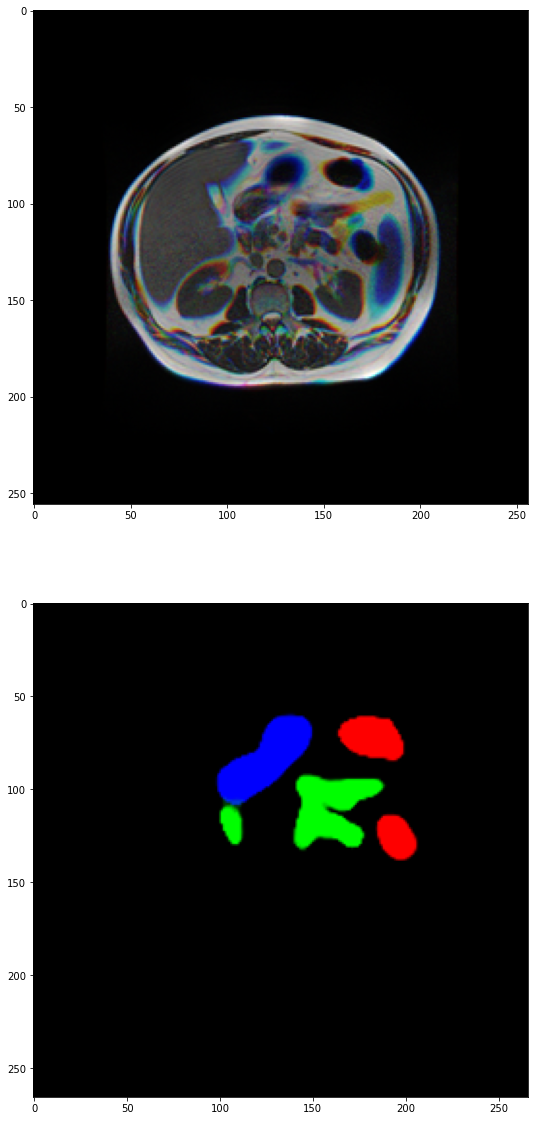

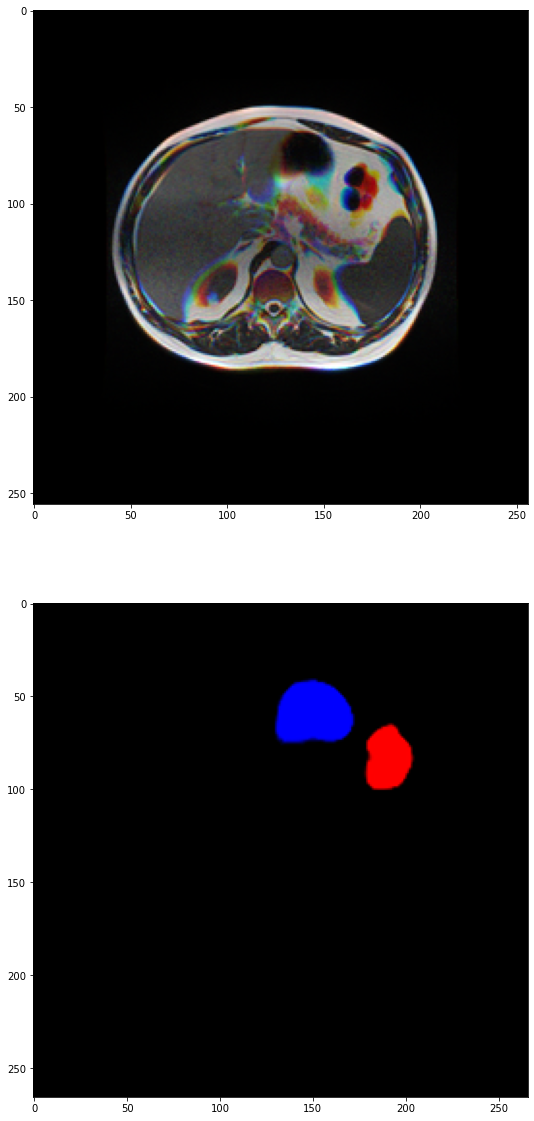

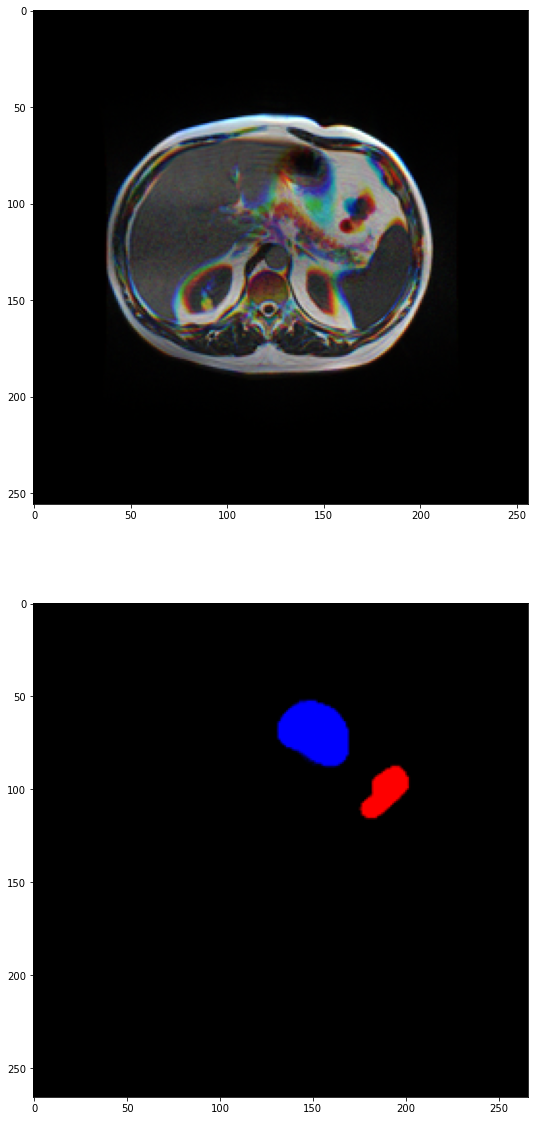

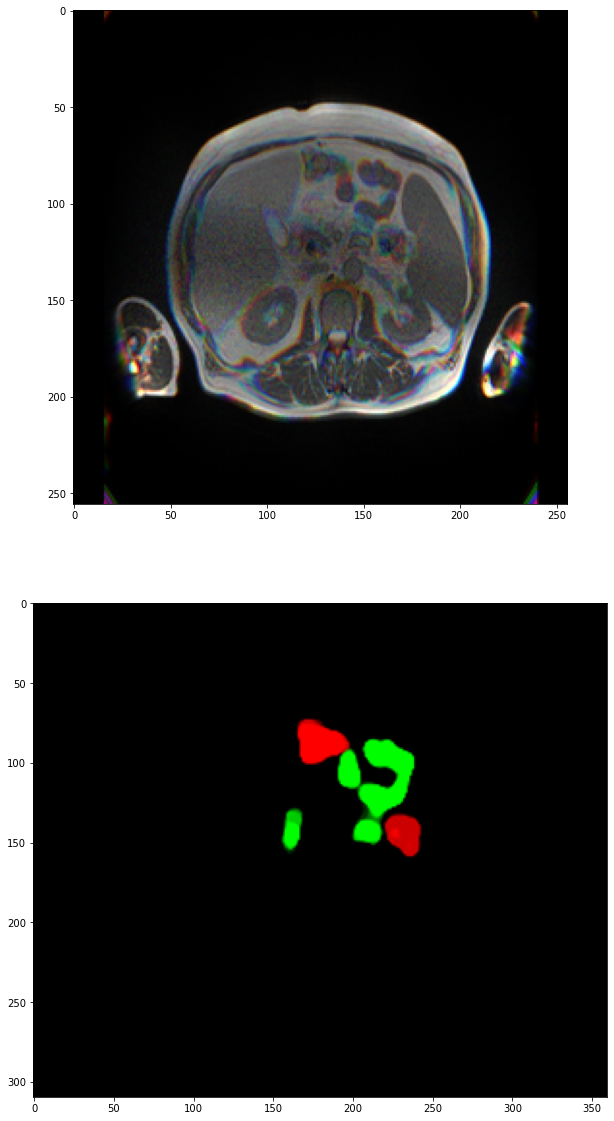

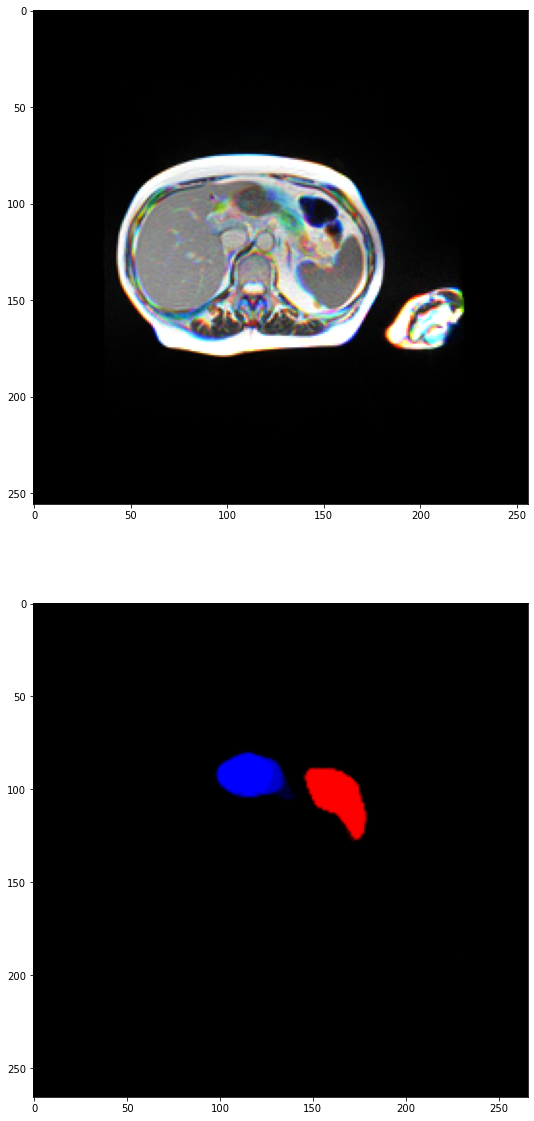

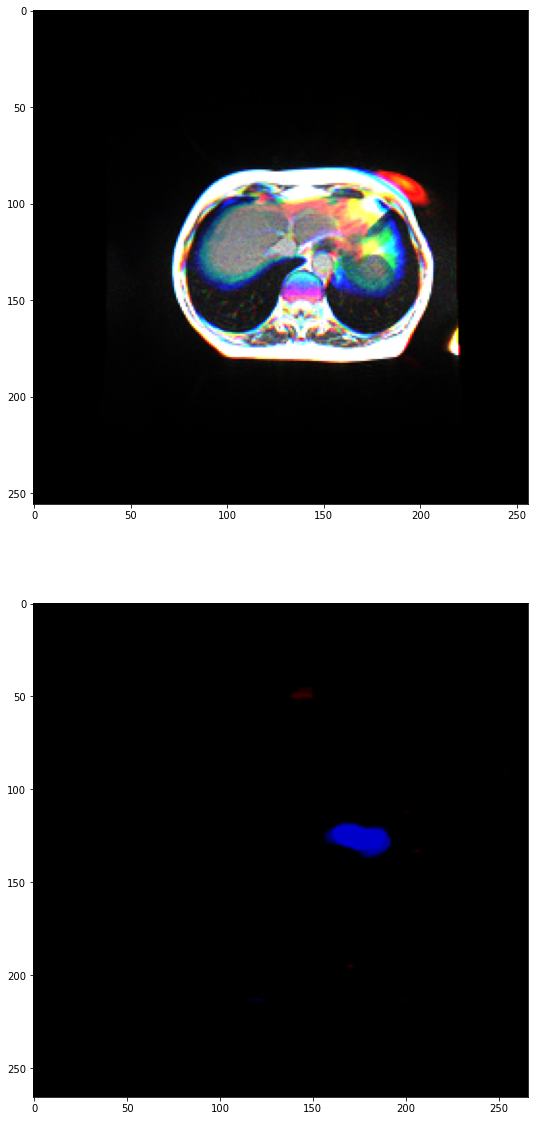

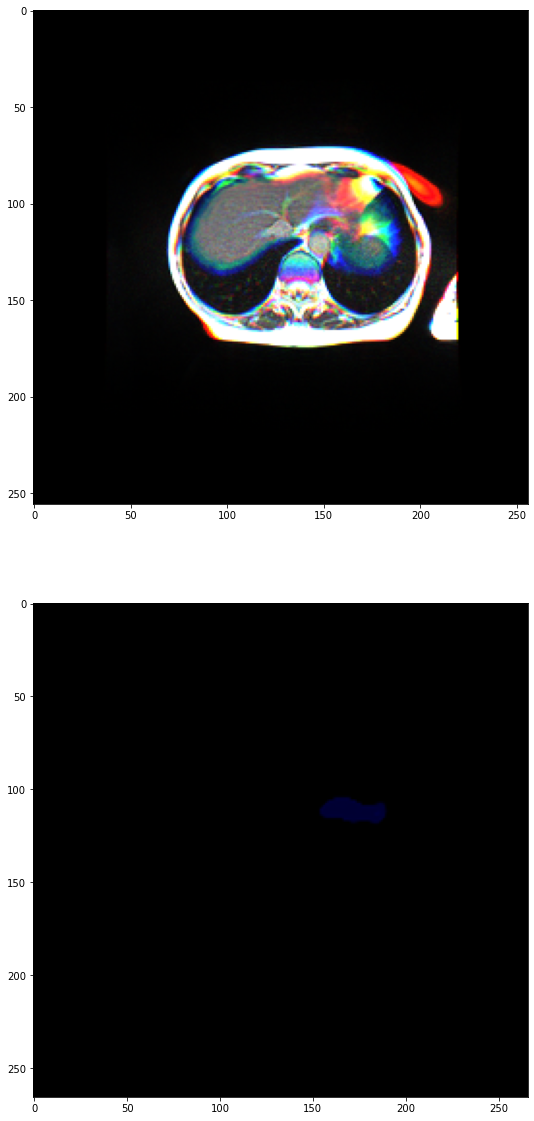

In [61]:

wts = np.array([1.0,1.0,1.0])

outputs = []

post_pred = Compose([
   # Activations(sigmoid=True),
    AsDiscrete(threshold=0.5),
])


torch.set_grad_enabled(False)
progress_bar = tqdm(range(len(test_dataloader)))
val_it = iter(test_dataloader)
for itr in progress_bar:
    batch = next(val_it)
    test_inputs = batch["image"].to(cfg.device)

    pred_all = []
    
    if True:
        # Do the Monai predictions
        model = monai_model()
        model.eval()
        for weights in cfg.weights:
            model.load_state_dict(torch.load(weights)['model'])
            pred = sliding_window_inference(test_inputs, cfg.img_size, cfg.sw_batch_size, model)
            pred = torch.nn.Sigmoid()(pred)
            pred_all.append(pred*wts[0])
            # do 4 tta
            for dims in [[2], [3], [2, 3]]:
                flip_pred = sliding_window_inference(torch.flip(test_inputs, dims=dims),
                                                     cfg.img_size, cfg.sw_batch_size, model)
                flip_pred = torch.flip(flip_pred, dims=dims)
                flip_pred = torch.nn.Sigmoid()(flip_pred)
                pred_all.append(flip_pred*wts[1])

        del model
    
    # Do the 2.5D predictions
    models = smp_model()
    
    
    
    image3D = rearrange(test_inputs[0,0], 'w h d -> d h w')
    
    d, w, h = image3D.shape
    
    res_image = torch.zeros(d,3,w,h)
    #print("0:", res_image.shape)
    #Pad it to handle the stride
    image3D = torch.vstack((torch.zeros((2,image3D.shape[1],image3D.shape[2])).to(DEVICE),
                             image3D,
                              torch.zeros((2,image3D.shape[1],image3D.shape[2])).to(DEVICE)))
    
    #print("1:", image3D.shape)
    #calculate image normalization
    stat = (image3D.flatten()*1.0).quantile(0.75).item()
    #print("main:",stat)
    #id_outputs = from_engine(["id"])(batch)[0]
    paths = from_engine(["path"])(batch)[0]
    
    #print(paths)
    
    #get the scaling
    #print(id_outputs[sl][0])
    #sel = df25d['id'] == id_outputs[0][0]
    #stat = df25d[sel]['max_img'].item()
    #print("2.5d:",stat)
    
    for sl in range(0,d):
        

        
        
        #img = transforms.ToTensor()(Image.open(paths[sl][0]))
        #img = img / (stat*5)
        
        #img3 = torch.zeros((3, img.shape[1], img.shape[2]),dtype=torch.float32)
        
        #img3[1,:,:] = img
        
        #if sl-2 >= 0:
        #    img = transforms.ToTensor()(Image.open(paths[sl-2][0]))
        #    img = img / (stat*5) # factor to make sure we don't clip
        #    img3[0,:,:] = img
 
        #if sl+2 < d:
        #    img = transforms.ToTensor()(Image.open(paths[sl+2][0]))
        #    img = img / (stat*5) # factor to make sure we don't clip
        #    img3[2,:,:] = img        
        
        #img3 = smp_transforms(img3.unsqueeze(0))
        
        image25D = image3D[[sl,sl+2,sl+4]]
        image25D = image25D.unsqueeze(0)
        image25D = image25D/(stat*5)
        image25D = smp_transforms(image25D)

            
        
        #image25D = img3.to(DEVICE)
        
        #print("2:", image25D.shape)
        #Take each of our fold models and average the outputs together
        with torch.no_grad():
            output = models[0](image25D)
            output = torch.nn.Sigmoid()(output)
            mask = output/n_folds
            for i in range(1,n_folds):
                output = models[i](image25D)
                output = torch.nn.Sigmoid()(output)
                mask = mask + output/n_folds       

                
        #From here we need to apply the invert of the the basic image crop and resize exactly to the mask image
        #and then apply run length encoding to that image

        mask = transforms.Resize((360,360),interpolation=transforms.InterpolationMode.BICUBIC)(mask) # undo resize to 288x288
        single_mask = transforms.functional.center_crop(mask,(image3D.shape[1],image3D.shape[2]))
        #print("3:", single_mask.shape)
        
        if sl == 80:
            
            print("image25d shape:", image25D.shape)
            print("min,max:",image25D.min(),image25D.max())
            #plt.imshow(rearrange(image25D[0].cpu().numpy(),'c h w -> h w c'),vmin=0,vmax=1.0)

            #print("img3 shape:", img3.shape)
            #print("min,max:",img3.min(),img3.max())
            #print("mask shape:", single_mask.shape)
            plt.figure(figsize=(20,20))
            plt.subplot(2,1,1)
            plt.imshow(rearrange(image25D[0].cpu().numpy(),'c h w -> h w c'),vmin=0,vmax=1.0)   
            plt.subplot(2,1,2)
            plt.imshow(rearrange(single_mask[0].cpu().numpy(),'c h w -> h w c'),vmin=0,vmax=1.0)
        
        
        
        res_image[sl] = single_mask
        
    del models 
    #print("4:", pred_all[0].shape)
    #print("5:", res_image.shape)
    
    
    res_image = rearrange(res_image,'d c w h -> 1 c h w d')
    
    #print("6:", res_image.shape)
    pred_all.append(res_image.to(DEVICE)*wts[2])
    
    pred_all = (torch.sum(torch.stack(pred_all), dim=0)/(wts.sum()))[0]
    
    
    
    pred_all = post_pred(pred_all)
    # c, w, h, d to d, c, h, w
    pred_all = torch.permute(pred_all, [3, 0, 2, 1]).cpu().numpy().astype(np.uint8)
    id_outputs = from_engine(["id"])(batch)[0]

    for test_output, id_output in zip(pred_all, id_outputs):
        id_name = id_output[0]
        lb, sb, st = test_output
        outputs.append([id_name, "large_bowel", rle_encode(lb)])
        outputs.append([id_name, "small_bowel", rle_encode(sb)])
        outputs.append([id_name, "stomach", rle_encode(st)])
        
    #break
    

In [286]:
pred_all[8].shape,res_image.shape,flip_pred.shape

(torch.Size([1, 3, 310, 360, 136]),
 torch.Size([1, 3, 310, 360, 136]),
 torch.Size([1, 3, 360, 310, 136]))

In [163]:
df25d.loc[sel]['max_img'].item()


3876.0

In [62]:
submit = pd.DataFrame(data=np.array(outputs), columns=["id", "class", "predicted"])

In [15]:
# Fix sub error, refers to: https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/320541
if not debug:
    sub_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
    del sub_df['predicted']
    sub_df = sub_df.merge(submit, on=['id','class'])
    sub_df.to_csv('submission.csv',index=False)
else:
    submit.to_csv('submission.csv', index=False)

## Compare error

In [63]:
def rle_decode_float(mask_rle, shape, color_val=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, color_val - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

    img = torch.zeros(shape[1]*shape[2])
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color_val
    return img.reshape(shape)    

In [64]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

In [65]:
def plot_masks(mask1,mask2):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(2,1,1)
    plt.imshow(rearrange(mask1.numpy(),'c h w -> h w c'), vmin=0, vmax=1.0, aspect=ratio)
    plt.title(f"mask1 Shape= {mask1[0].shape}")
    plt.axis('off')
    plt.subplot(2,1,2)
    plt.imshow(rearrange(mask2.numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"mask2 Shape = {mask2[0].shape}")
    plt.axis('off')
    

In [39]:
df25d = pd.read_csv("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/results/df25d_6-2.csv",index_col = [0])

In [66]:
train_df = pd.read_csv(ROOT_FOLDER + 'train.csv')[:1000*3]

In [67]:
#merge the 3 segmentations into one row
train_df = train_df.pivot(index="id", columns="class", values="segmentation")
submit_piv = submit.pivot(index="id", columns="class", values="predicted")

In [68]:
# Join the sub with the train metadata
joined_df = train_df.merge(submit_piv, on='id')

In [69]:
#replace NaN with ''
joined_df.fillna('',inplace=True)

In [70]:
joined_df = joined_df.merge(test_df[['id','image_path','height','width']], on='id')

In [71]:
from PIL import Image
import matplotlib.pyplot as plt

In [72]:
metric = 0
pbar = tqdm(total=len(joined_df))
for idx in range(0,len(joined_df)):
    row = joined_df.iloc[idx]
    #print(row)
    img = transforms.ToTensor()(Image.open(row.image_path))
    mask_gt = torch.zeros((3, img.shape[1], img.shape[2]))
    
    lb_class_seg = row.large_bowel_x
    sb_class_seg = row.small_bowel_x
    st_class_seg = row.stomach_x
    
    
    
    if type(lb_class_seg) is str:
        mask_gt[0,:,:] = rle_decode_float(lb_class_seg,img.shape,color_val=1)

    if type(sb_class_seg) is str:
        mask_gt[1,:,:] = rle_decode_float(sb_class_seg, img.shape,color_val=1)

    if type(st_class_seg) is str:
        mask_gt[2,:,:] = rle_decode_float(st_class_seg, img.shape,color_val=1)    
    
    
    
    mask_p = torch.zeros((3, img.shape[1], img.shape[2]))
    
    lb_class_seg = row.large_bowel_y
    sb_class_seg = row.small_bowel_y
    st_class_seg = row.stomach_y
    
    
    
    if type(lb_class_seg) is str:
        mask_p[0,:,:] = rle_decode_float(lb_class_seg,img.shape,color_val=1)

    if type(sb_class_seg) is str:
        mask_p[1,:,:] = rle_decode_float(sb_class_seg, img.shape,color_val=1)

    if type(st_class_seg) is str:
        mask_p[2,:,:] = rle_decode_float(st_class_seg, img.shape,color_val=1)    
    
    
    metric += dice_coef(mask_gt.unsqueeze(0),mask_p.unsqueeze(0))
    
    #plot_masks(mask_gt,mask_p)
    
    pbar.update(1)
    #break
pbar.close()  

metric /= len(joined_df)

print("metric = ",metric)
    

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 359.26it/s]

metric =  tensor(0.9568)


In [112]:
metric

tensor(1.)

In [224]:
joined_df

,id,large_bowel_x,small_bowel_x,stomach_x,large_bowel_y,small_bowel_y,stomach_y,image_path,height,width
0,case123_day0_slice_0001,,,,1 24044 24046 265 24312 265 24578 265 24844 50...,1 26438 26440 2689 29131 790 29923 2223 32147 ...,1 31520 31522 265 31788 1328 33120 1 33122 37635,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266
1,case123_day0_slice_0002,,,,1 21117 21119 265 21385 265 21651 265 21917 26...,1 14462 14465 6653 21119 265 21385 265 21651 2...,1 70756,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266
2,case123_day0_slice_0003,,,,1 70756,1 70756,1 65259 65264 5493,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266
3,case123_day0_slice_0004,,,,1 70756,1 41550 41552 265 41818 3 41822 261 42084 3 42...,1 70756,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266
4,case123_day0_slice_0005,,,,1 15744 15746 43788 59535 11222,1 16664 16666 268 16935 801 17739 16250 33991 ...,1 70756,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266
...,...,...,...,...,...,...,...,...,...,...
995,case77_day20_slice_0140,,,,1 24138 24140 265 24406 265 24673 264 24939 26...,1 137 160 37282 37443 265 37709 265 37975 265 ...,1 70756,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266
996,case77_day20_slice_0141,,,,1 23872 23874 265 24141 264 24407 264 24673 26...,1 30655 30657 19836 50495 1331 51827 258 52086...,1 70756,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266
997,case77_day20_slice_0142,,,,1 27998 28000 265 28266 2390 30657 40100,1 70756,1 57141 57143 265 57409 265 57675 13082,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266
998,case77_day20_slice_0143,,,,1 20826 20828 6643 27472 2124 29597 265 29863 ...,1 11028 11032 8203 19236 265 19502 4611 24115 ...,1 62844 62846 258 63105 6 63112 258 63371 6 63...,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266


In [143]:
df25d.columns

Index(['large_bowel', 'small_bowel', 'stomach', 'id', 'case_id_str', 'case_id',
       'day_num_str', 'day_num', 'slice_id', 'slice_num', 'match', 'subpath',
       'filename', 'im_height', 'im_width', 'im_pixel_height',
       'im_pixel_width', 'slice_thickness', 'segmentations', 'fold', 'max',
       'max_img', 'subpath_00', 'subpath_01', 'subpath_02', 'subpaths',
       'ilocid', 'dice'],
      dtype='object')

In [97]:
test_df

,id,case,day,slice,image_path,height,width,case_id_str,day_num_str,slice_id
0,case123_day20_slice_0001,123,20,1,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266,case123,day20,slice_0001
1,case123_day20_slice_0002,123,20,2,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266,case123,day20,slice_0002
2,case123_day20_slice_0003,123,20,3,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266,case123,day20,slice_0003
3,case123_day20_slice_0004,123,20,4,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266,case123,day20,slice_0004
4,case123_day20_slice_0005,123,20,5,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,266,266,case123,day20,slice_0005
...,...,...,...,...,...,...,...,...,...,...
995,case133_day0_slice_0132,133,0,132,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,310,360,case133,day0,slice_0132
996,case133_day0_slice_0133,133,0,133,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,310,360,case133,day0,slice_0133
997,case133_day0_slice_0134,133,0,134,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,310,360,case133,day0,slice_0134
998,case133_day0_slice_0135,133,0,135,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,310,360,case133,day0,slice_0135


In [99]:
train_df

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
2995,case133_day0_slice_0135,small_bowel,NaN
2996,case133_day0_slice_0135,stomach,NaN
2997,case133_day0_slice_0136,large_bowel,NaN
2998,case133_day0_slice_0136,small_bowel,NaN
